In [19]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
from paf_loader import Loader, load_confidence_map_and_paf
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.evaluation import pcp
from mvpose import settings
from os.path import isfile, join

data_root = Settings['data_root']

params = settings.get_settings(scale_to_mm=1000,
                               min_nbr_joints=5,
                               max_epi_distance=25)

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

# ----------------------------------
# ==================================
# default
seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'
# ----------------------------------


# seq1_zipname = 'player2sequence2.zip'
# seq1_dir = 'Sequence 2'
# ==================================
# ----------------------------------


# ====================================================
# Extractor Functions
# ====================================================
def extract_best(pos3d, Humans, alpha):
    """
        Extracts the best fitting human for the calculation
    """
    larms = 0
    uarms = 0
    ulegs = 0
    llegs = 0
    all_parts = 0
    
    for h in Humans:
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        if all_parts < r.all_parts:
            larms = r.lower_arms
            uarms = r.upper_arms
            ulegs = r.upper_legs
            llegs = r.lower_legs
    
    return {
        "larms": larms,
        "uarms": uarms,
        "ulegs": ulegs,
        "llegs": llegs
    }


def apply(frame, alpha, loader):
    """
    """
    global seq1_zipname
    global seq1_zip
    global EXP_NBR
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=2)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame, dir=Settings['tmp'])
    
    
#     fname = join('/tmp', EXP_NBR + "_frame" + str(frame) + '.npy')
#     if isfile(fname):
#         detections = np.load(fname)
#     else:
    detections = pose.estimate(Calib, heatmaps, pafs, 
                           settings=params)
#         np.save(fname, detections)
    
    detections = gen.apply(detections)
    
    Humans = kth.transform3d_from_mscoco(detections)
    result1 = extract_best(pos3d, Humans, alpha)
    
    # ---------------------------------
    
    
#     detections = gen.apply(detections)
#     Humans = kth.transform3d_from_mscoco(detections)
#     result2 = extract_best(pos3d, Humans, alpha)
    
    del Im
    del Calib
    del pos2d
    del pos3d
    del heatmaps
    del pafs
    del detections
    del Humans
    
    #return result1, result2
    return result1

In [2]:
def run_experiment():
    
    loader = Loader(with_gpu=True)

    alpha = 0.5

    larms = []
    uarms = []
    llegs = []
    ulegs = []

    # 0 .. 214
    for frame in range(0, 214):
        _start = time()
        result = apply(frame, alpha, loader)
        larms.append(result['larms'])
        uarms.append(result['uarms'])
        llegs.append(result['llegs'])
        ulegs.append(result['ulegs'])

        _end = time()
        print('frame ' + str(frame) + ', elapsed', _end - _start)
    
    return larms, uarms, llegs, ulegs

larms, uarms, llegs, ulegs = run_experiment()

frame 0, elapsed 5.8117992877960205
frame 1, elapsed 2.402113676071167
frame 2, elapsed 2.3418188095092773
frame 3, elapsed 2.350482225418091
frame 4, elapsed 2.466275215148926
frame 5, elapsed 2.5309042930603027
frame 6, elapsed 2.423793077468872
frame 7, elapsed 2.4594316482543945
frame 8, elapsed 2.3240389823913574
frame 9, elapsed 2.3422622680664062
frame 10, elapsed 2.365694046020508
frame 11, elapsed 2.3259518146514893
frame 12, elapsed 2.425952911376953
frame 13, elapsed 2.4447035789489746
frame 14, elapsed 2.4484400749206543
frame 15, elapsed 2.3836252689361572
frame 16, elapsed 3.114149332046509
frame 17, elapsed 2.7217957973480225
frame 18, elapsed 2.6431896686553955
frame 19, elapsed 2.564540147781372
frame 20, elapsed 2.535895586013794
frame 21, elapsed 2.5568878650665283
frame 22, elapsed 2.4211554527282715
frame 23, elapsed 2.465327501296997
frame 24, elapsed 2.3779866695404053
frame 25, elapsed 2.305945873260498
frame 26, elapsed 2.4410629272460938
frame 27, elapsed 2.35

## No unary (simple)
* upper arms:	 0.955607476635514
* lower arms:	 0.822429906542056
* upper legs:	 0.9439252336448598
* lower legs:	 0.883177570093458

# With unary (simple)
* upper arms:	 0.955607476635514
* lower arms:	 0.8247663551401869
* upper legs:	 0.9439252336448598
* lower legs:	 0.897196261682243

# Like in Master thesis with Xi = 0
* upper arms:	 0.9532710280373832
* lower arms:	 0.7990654205607477
* upper legs:	 0.9602803738317757
* lower legs:	 0.9345794392523364

# Like in Master thesis with Xi = 0.5
* upper arms:	 0.955607476635514
* lower arms:	 0.8271028037383178
* upper legs:	 0.9439252336448598
* lower legs:	 0.9065420560747663

# Like in Master thesis with Xi = 0.7 (x)
* upper arms:	 0.9532710280373832
* lower arms:	 0.8341121495327103
* upper legs:	 0.9485981308411215
* lower legs:	 0.9135514018691588
* avg:		 0.9123831775700935

# Like in Master thesis without unary
* upper arms:	 0.9532710280373832
* lower arms:	 0.8341121495327103
* upper legs:	 0.9462616822429907
* lower legs:	 0.8995327102803738
* avg:		 0.9082943925233645

# Like in Master thesis with Xi = 0.7 and PC
* upper arms:	 0.9602803738317757
* lower arms:	 0.9088785046728972
* upper legs:	 0.9509345794392523
* lower legs:	 0.9182242990654206
* avg:		 0.9345794392523366

In [3]:
print("upper arms:\t", np.mean(uarms))
print("lower arms:\t", np.mean(larms))
print("upper legs:\t", np.mean(ulegs))
print("lower legs:\t", np.mean(llegs))
print('avg:\t\t', np.mean([
    np.mean(uarms), np.mean(larms), np.mean(ulegs), np.mean(llegs)
]))

upper arms:	 0.9602803738317757
lower arms:	 0.9088785046728972
upper legs:	 0.9509345794392523
lower legs:	 0.9182242990654206
avg:		 0.9345794392523366


No handles with labels found to put in legend.


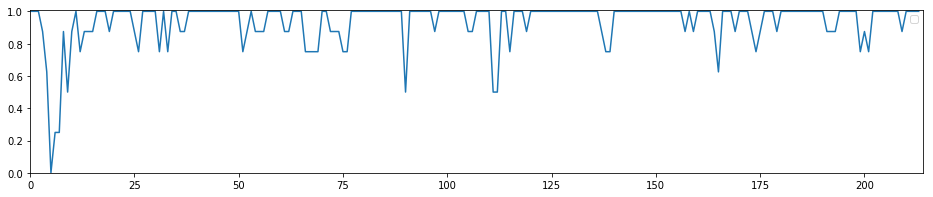

In [14]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
x = range(0, len(uarms))

# ax.plot(x, uarms, label='uarms')
# ax.plot(x, larms, label='larms')
# ax.plot(x, ulegs, label='ulegs')
# ax.plot(x, llegs, label='llegs')

mu = np.mean([uarms, larms, ulegs, llegs], axis=0)
ax.plot(x, mu)

ax.set_xlim([0, 214])
ax.set_ylim([0, 1.01])

plt.legend()
plt.show()

mu at frame 5: 0.0
step 1: elapsed 0.2522304058074951
step 2: elapsed 0.0032358169555664062
step 3: elapsed 0.01421499252319336
step 4: elapsed 0.2931981086730957
-------------------------------------------
Handle transitivity:
	Intra:		 13
	Intra(choice):	 2
	Inter:		 88
	Inter(choice):	 65
-------------------------------------------
	Time =  119  ms
	result: 0

	Total cost: 137.94706527658707

# valid points:		 35
# invalid points:	 8
step 5: elapsed 0.1211848258972168
(smart candidate selection) [
	Time =  1  ms
	result: 0

	Total cost: 1.6726501440118429
] (smart candidate selection)
step 6: elapsed 0.0038394927978515625


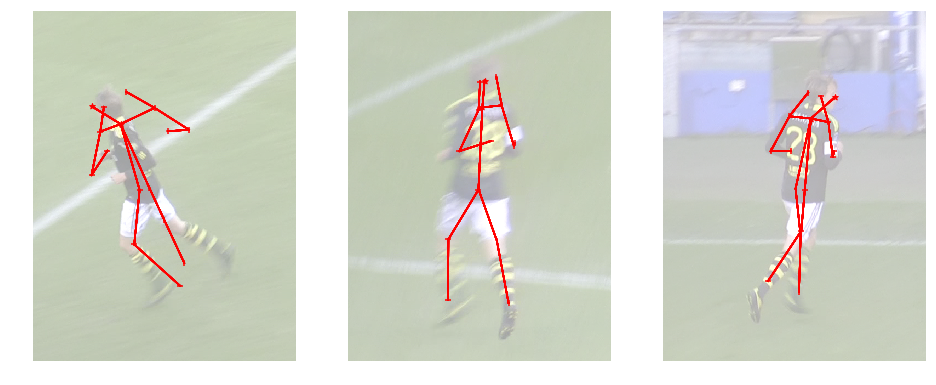

In [24]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

frame = 5
tmp = '/tmp'

print('mu at frame ' + str(frame) + ":", mu[frame])

Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, frame, player=2)
heatmaps, pafs = load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, frame, dir=tmp)
_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=params, debug=True)


Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()

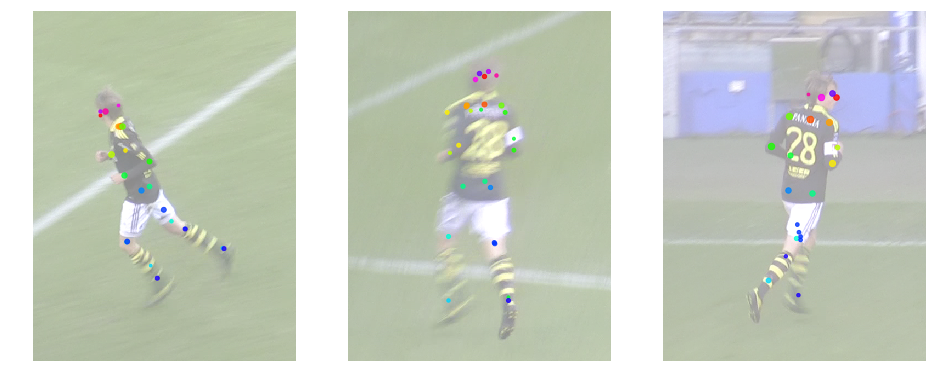

In [25]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.set_xlim([0, 480])
    ax.set_ylim([640, 0])
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers2d_with_w = Debug.candidates2d.peaks2d[cid][jid]
        if len(centers2d_with_w) == 0:
            continue
        centers2d = centers2d_with_w[:,0:2].astype('float32')
        score = centers2d_with_w[:,2]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
    
plt.show()

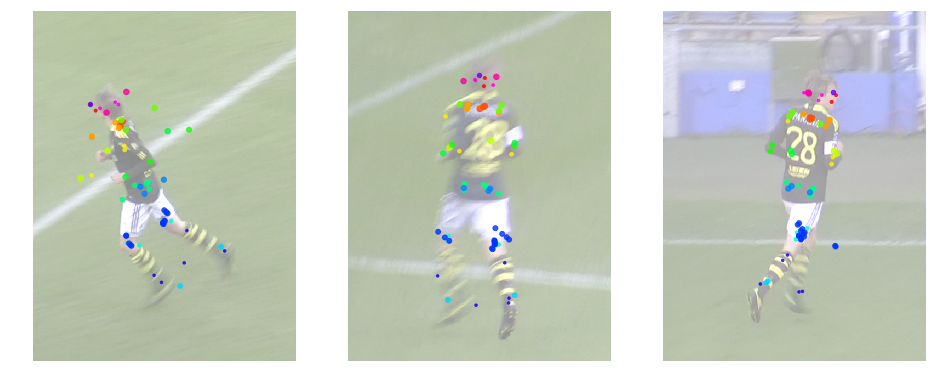

In [26]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.triangulation.peaks3d_weighted[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
                #ax.text(x, y, str(jid))
    
plt.show()

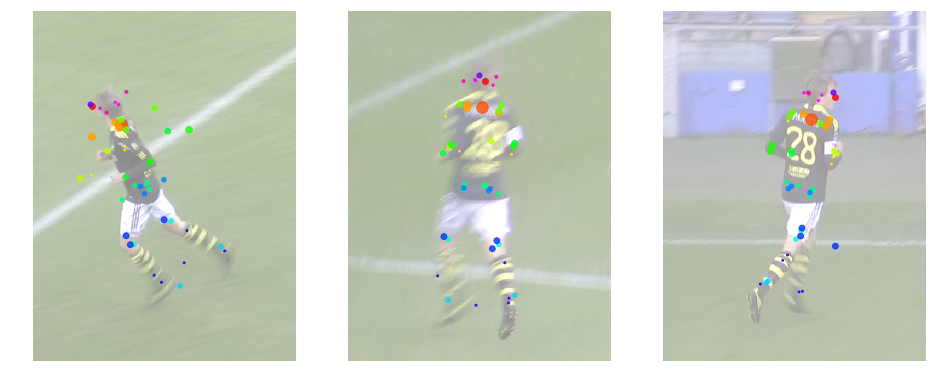

In [27]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
                #ax.text(x, y, str(jid))
    
plt.show()

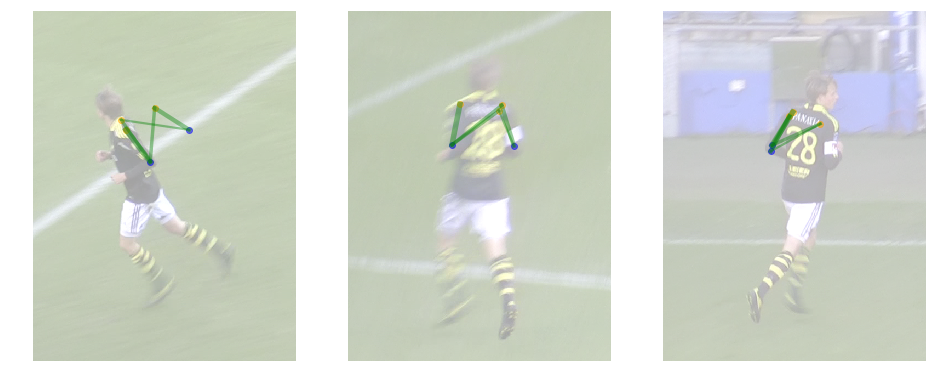

In [34]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

# left leg = 11
# right arm = 2,3
# left arm = 4,5
LIMB_ID = 4
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    sq_maskA = np.squeeze(maskA[0])
    sq_maskB = np.squeeze(maskB[0])
    if len(sq_maskA.shape) == 0:
        sq_maskA = np.expand_dims(sq_maskA, axis=0)
    if len(sq_maskB.shape) == 0:
        sq_maskB = np.expand_dims(sq_maskB, axis=0)
    
    for _a in sq_maskA:
        for _b in sq_maskB:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            elif w > -99999:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

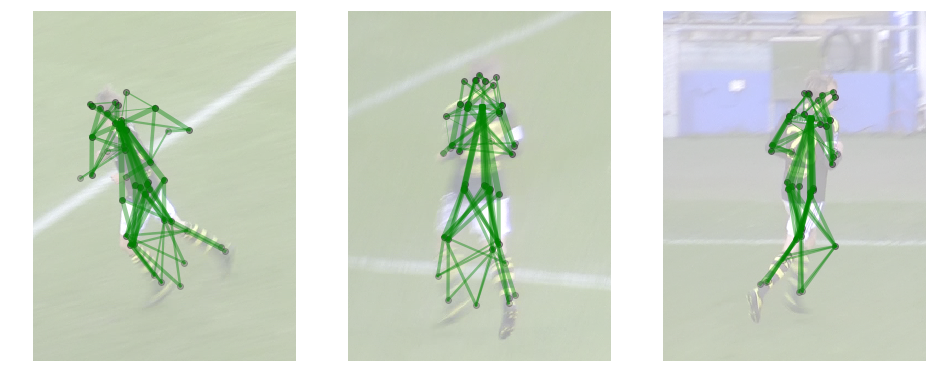

In [29]:
import numpy.linalg as la

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='black', alpha=0.2)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='black', alpha=0.2)
        
        sq_maskA = np.squeeze(maskA[0])
        sq_maskB = np.squeeze(maskB[0])
        if len(sq_maskA.shape) == 0:
            sq_maskA = np.expand_dims(sq_maskA, axis=0)
        if len(sq_maskB.shape) == 0:
            sq_maskB = np.expand_dims(sq_maskB, axis=0)
        
        min_length, max_length = params.sensible_limb_length[lid]
        
        for _a in sq_maskA:
            for _b in sq_maskB:
                p3dA = candA[_a]
                p3dB = candB[_b]
                distance = la.norm(p3dA - p3dB)
                lstype = '-'
                if distance < min_length or distance > max_length:
                    lstype = ':'
                    
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', 
                            linestyle=lstype, linewidth=w*10, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', 
                            linestyle=lstype, linewidth=-w*10, alpha=0.4)

plt.show()